In [1]:
!pip install rdkit
!pip install networkx
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [2]:
import gdown
import pandas as pd
import torch
from rdkit import Chem
from torch_geometric.data import Data, Batch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [3]:
from google.colab import drive

drive.mount('/content/drive')

# Load the CSV dataset
data = pd.read_csv('/content/drive/MyDrive/CS 566/Notebooks/DDI.csv')
# data = pd.read_csv('/content/DDI.csv')
print(data.shape)

Mounted at /content/drive
(192231, 11)


In [4]:
data.head()

,Drug1_ID_1,Drug1,Drug2_ID_1,Drug2,Y_1,Y.1_1,Drug1_ID_2,Drug2_ID_2,Y_2,Y.1_2,merge_key
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,#Drug1 may increase the photosensitizing activ...,DB04571,DB00460,1,abdominal pain,DB04571_DB00460
1,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,#Drug1 may increase the photosensitizing activ...,DB09536,DB00460,1,abdominal pain,DB09536_DB00460
2,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,#Drug1 may increase the photosensitizing activ...,DB01600,DB00460,1,abdominal pain,DB01600_DB00460
3,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,#Drug1 may increase the photosensitizing activ...,DB09000,DB00460,1,abdominal pain,DB09000_DB00460
4,DB11630,OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)...,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1,#Drug1 may increase the photosensitizing activ...,DB11630,DB00460,1,abdominal pain,DB11630_DB00460


In [5]:
data.describe()

,Y_1,Y_2
count,192231.000000,192231.000000
mean,49.841706,49.841706
std,19.032166,19.032166
min,1.000000,1.000000
25%,47.000000,47.000000
50%,49.000000,49.000000
75%,68.000000,68.000000
max,86.000000,86.000000


In [6]:

# import pandas as pd

# # Assuming your DataFrame is named df

# # Extract unique values for Y_1 and their corresponding definitions
# unique_Y_1 = data[['Y_1', 'Y.1_1']].drop_duplicates().reset_index(drop=True)

# # Rename columns for clarity
# unique_Y_1.columns = ['Y_1', 'Y_1_definition']

# # Extract unique values for Y_2 and their corresponding definitions
# unique_Y_2 = data[['Y_2', 'Y.1_2']].drop_duplicates().reset_index(drop=True)

# # Rename columns for clarity
# unique_Y_2.columns = ['Y_2', 'Y_2_definition']

# # Merge the two DataFrames on index to ensure alignment
# unique_values_df = pd.concat([unique_Y_1, unique_Y_2], axis=1)

# # Save the unique values to a CSV file
# unique_values_df.to_csv('unique_values_with_definitions.csv', index=False)

import pandas as pd

# Assuming your DataFrame is named df

# Extract unique values for Y_1 and their corresponding definitions, and sort them
unique_Y_1 = data[['Y_1', 'Y.1_1']].drop_duplicates().sort_values(by='Y_1').reset_index(drop=True)

# Rename columns for clarity
unique_Y_1.columns = ['Y_1', 'Y_1_definition']

# Extract unique values for Y_2 and their corresponding definitions, and sort them
unique_Y_2 = data[['Y_2', 'Y.1_2']].drop_duplicates().sort_values(by='Y_2').reset_index(drop=True)

# Rename columns for clarity
unique_Y_2.columns = ['Y_2', 'Y_2_definition']

# Merge the two DataFrames on index to ensure alignment
unique_values_df = pd.concat([unique_Y_1, unique_Y_2], axis=1)

# Save the unique values to a CSV file
unique_values_df.to_csv('unique_values_with_definitions.csv', index=False)


In [7]:
data['Y_1'] = ((data['Y_1'] - data['Y_1'].min()) * (20) / (data['Y_1'].max() - data['Y_1'].min()))
data['Y_2'] = ((data['Y_2'] - data['Y_2'].min()) * (20) / (data['Y_2'].max() - data['Y_2'].min()))


In [8]:
data.describe()

,Y_1,Y_2
count,192231.000000,192231.000000
mean,11.492166,11.492166
std,4.478157,4.478157
min,0.000000,0.000000
25%,10.823529,10.823529
50%,11.294118,11.294118
75%,15.764706,15.764706
max,20.000000,20.000000


In [9]:
def molecule_to_graph(molecule):
    num_atoms = molecule.GetNumAtoms()
    x = torch.tensor([atom_feature_vector(atom) for atom in molecule.GetAtoms()], dtype=torch.float)
    edge_index = []
    edge_attr = []
    for bond in molecule.GetBonds():
        edge_index.extend([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()], [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]])
        edge_attr.extend([bond_feature_vector(bond), bond_feature_vector(bond)])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def atom_feature_vector(atom):
    return [atom.GetAtomicNum(), atom.GetDegree(), atom.GetHybridization()]

def bond_feature_vector(bond):
    return [bond.GetBondTypeAsDouble(), bond.IsInRing()]

def visualize(graph):
    nx_graph = to_networkx(graph, to_undirected=True)

    fig = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)

    nx.draw_networkx(nx_graph, pos, with_labels=True, node_size=500, font_size=12, font_weight='bold')

    if 'edge_attr' in next(iter(nx_graph.edges(data=True)))[-1]:
        edge_labels = {(u, v): d['edge_attr'] for u, v, d in nx_graph.edges(data=True)}
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.axis('off')
    plt.show()

In [10]:
data = data.sample(frac=0.01)


In [11]:
import torch
from rdkit import Chem
from torch_geometric.data import Data
import numpy as np
# Define function placeholders (atom_feature_vector, bond_feature_vector, molecule_to_graph) here
graphs = []
indices = []
count = 0
def process_data(data):
    for _, row in data.iterrows():
        idx_dict = {}
        try:
            molecule1 = Chem.MolFromSmiles(row['Drug1'])
            molecule2 = Chem.MolFromSmiles(row['Drug2'])

            # Check if molecules are None (indicating parsing failure)
            if molecule1 is None or molecule2 is None:
                print("Parsing error: Skipping row due to invalid SMILES.")
                continue

            graph1 = molecule_to_graph(molecule1)
            graph2 = molecule_to_graph(molecule2)

            ddi_features = torch.tensor([[
                row['Y_1'] ,
                row['Y_2']
            ]], dtype=torch.float)

            ddi_features_node_index = graph1.x.shape[0] + graph2.x.shape[0]
            pad_size = graph1.x.shape[1] - ddi_features.shape[1]

            ddi_features_padded = torch.cat([ddi_features,torch.zeros((ddi_features.shape[0],pad_size))],dim=1)

            combined_x = torch.cat([graph1.x, graph2.x, ddi_features_padded])

            combined_x_idx = [[], [], []]
            combined_x_idx[0] = np.arange(0,graph1.x.shape[0]) # graph 1 node indices
            combined_x_idx[1] = np.arange(graph1.x.shape[0],graph1.x.shape[0]+graph2.x.shape[0]) # graph 2 node indices
            combined_x_idx[2] = np.arange(graph1.x.shape[0]+graph2.x.shape[0],graph1.x.shape[0]+graph2.x.shape[0]+1) # y node index


            idx_dict["node"] = combined_x_idx

            # Create edges between each node in graph1 and the "Catalyst Score" node
            graph1_to_y_edge_index = torch.cat([
                torch.tensor([[i, ddi_features_node_index] for i in range(graph1.x.shape[0])])
            ], dim=0).t().contiguous()

            '''
                Create edges between each node in graph2 and the "Catalyst Score" node. Note that a graph.x.shape[0] offset
                is required so that the edge indices are offset
            '''
            graph2_to_y_edge_index = torch.cat([
                torch.tensor([[i + graph1.x.shape[0], ddi_features_node_index] for i in range(graph2.x.shape[0])])
            ], dim=0).t().contiguous()

            # Combine the edge indices
            combined_edge_index = torch.cat([graph1.edge_index, graph2.edge_index + graph1.x.shape[0], graph1_to_y_edge_index, graph2_to_y_edge_index], dim=1)

            combined_edge_index_idx = [[], [], []]
            combined_edge_index_idx[0] = np.arange(0,graph1.edge_index.shape[1]) # graph 1 edge index' indices
            combined_edge_index_idx[1] = np.arange(graph1.edge_index.shape[1],graph1.edge_index.shape[1]+graph2.edge_index.shape[1]) # graph 2 edge index' indices
            combined_edge_index_idx[2] = np.arange(graph1.edge_index.shape[1]+graph2.edge_index.shape[1],
                                graph1.edge_index.shape[1]+graph2.edge_index.shape[1]+graph1_to_y_edge_index.shape[1]+graph2_to_y_edge_index.shape[1]) # y edge index' index

            idx_dict["edge_index"] = combined_edge_index_idx

            # Edge connections from every other node to Y node
            graph1_to_y_edge_attr = torch.ones((graph1_to_y_edge_index.shape[1], graph1.edge_attr.shape[1]), dtype=torch.float)
            graph2_to_y_edge_attr = torch.ones((graph2_to_y_edge_index.shape[1], graph2.edge_attr.shape[1]), dtype=torch.float)

            # Combine the edge attributes
            combined_edge_attr = torch.cat([graph1.edge_attr, graph2.edge_attr, graph1_to_y_edge_attr, graph2_to_y_edge_attr])

            combined_edge_attr_idx = [[], [], []]
            combined_edge_attr_idx[0] = np.arange(0,graph1.edge_attr.shape[0]) # graph 1 edge attr' indices
            combined_edge_attr_idx[1] = np.arange(graph1.edge_attr.shape[0],graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0]) # graph 2 edge attr' indices
            combined_edge_attr_idx[2] = np.arange(graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0],
                                graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0]+graph1_to_y_edge_attr.shape[0]+graph2_to_y_edge_attr.shape[0]) # y edge attr' index

            idx_dict["edge"] = combined_edge_attr_idx

            # Create the combined graph
            combined_graph = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=ddi_features)
            graphs.append(combined_graph)
            indices.append(idx_dict)

        except Exception as e:
            continue  # Skip this row and proceed to the next one

    return graphs

# Call the function with your data
# process_data(your_data)


In [12]:
grap = process_data(data)

In [14]:
print(len(grap))

1910


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import torch
from torch_geometric.nn import GCNConv, NNConv, BatchNorm
from torch_geometric.data import Data

class DDIGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_channels):
        super(DDIGNN, self).__init__()
        self.conv1 = NNConv(in_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, in_channels * hidden_channels))
        self.bn1 = BatchNorm(hidden_channels)

        self.conv1b = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn1b = BatchNorm(hidden_channels)

        self.conv2 = NNConv(in_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, in_channels * hidden_channels))
        self.bn2 = BatchNorm(hidden_channels)

        self.conv2b = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn2b = BatchNorm(hidden_channels)

        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn3 = BatchNorm(hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def l2_regularization(self):
        l2_reg = 0
        for param in self.parameters():
            l2_reg += torch.sum(param ** 2)
        return l2_reg

    def forward(self, graph):
        v=graph.x
        edge_index = graph.edge_index
        e = graph.edge_attr
        indices = graph.indices

        v1 = v[torch.tensor(indices["node"][0][0])]
        v2 = v[torch.tensor(indices["node"][0][1])]

        e1 = e[torch.tensor(indices["edge"][0][0])]
        e2 = e[torch.tensor(indices["edge"][0][1])]
        e3 = e[torch.tensor(indices["edge"][0][2])]

        eidx1 = edge_index[:, torch.tensor(indices["edge_index"][0][0])]
        eidx2 = torch.sub(edge_index[:, torch.tensor(indices["edge_index"][0][1])], v1.shape[0])
        eidx3 = edge_index[:, torch.tensor(indices["edge_index"][0][2])]

        graph1 = self.conv1(v1, eidx1, e1)
        graph1 = self.bn1(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        graph1 = self.conv1b(graph1, eidx1, e1)
        graph1 = self.bn1b(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        graph2 = self.conv2(v2, eidx2, e2)
        graph2 = self.bn2(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        graph2 = self.conv2b(graph2, eidx2, e2)
        graph2 = self.bn2b(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        combined_nodes = torch.cat((graph1, graph2, torch.zeros(1, graph1.shape[1])), dim=0)
        v3 = self.conv3(combined_nodes, eidx3, e3)
        v3 = self.bn3(v3)
        v3 = torch.nn.functional.elu(v3)
        v3 = self.dropout(v3[-1])

        v3 = self.fc1(v3)
        v3 = torch.nn.functional.elu(v3)

        v3 = self.fc2(v3)
        v3 = torch.nn.functional.elu(v3)

        return v3

In [18]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import KFold

# Assuming 'graphs' and 'indices' are provided somewhere in your code

data = []
for graph, index in zip(graphs, indices):
    graph.indices = index
    data.append(graph)

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Create a KFold object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define model, optimizer, and loss function
model = DDIGNN(in_channels=3, hidden_channels=40, out_channels=2, edge_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
l2_weight = 0.01
loss_fn = torch.nn.MSELoss()

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2

num_epochs = 40
patience = 10  # Number of epochs to wait for improvement

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split the data into train and validation sets for the current fold
    train_dataset = [data[i] for i in train_idx]
    val_dataset = [data[i] for i in val_idx]

    # Create DataLoaders for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        for graph in train_loader:
            output = model(graph)
            loss = loss_fn(output, graph.y.float()) + model.l2_regularization()
            optimizer.zero_grad()
            loss.backward()
            with torch.no_grad():
                optimizer.step()
            total_train_loss += loss.item()
            train_preds.append(output.detach())
            train_targets.append(graph.y.detach())

        train_preds = torch.cat(train_preds).view(-1, 2)
        train_targets = torch.cat(train_targets)
        train_r2 = r2_score(train_targets, train_preds)
        train_loss = total_train_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for graph in val_loader:
                output = model(graph)
                loss = loss_fn(output, graph.y.float())
                total_val_loss += loss.item()
                val_preds.append(output.detach())
                val_targets.append(graph.y.detach())

        val_preds = torch.cat(val_preds).view(-1, 2)
        val_targets = torch.cat(val_targets)
        val_r2 = r2_score(val_targets, val_preds)
        val_loss = total_val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}, Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print()

Fold 1/5


KeyboardInterrupt: 

In [ ]:
import pickle

with open('ddi_model.pkl', 'wb') as f:

    pickle.dump(model, f)

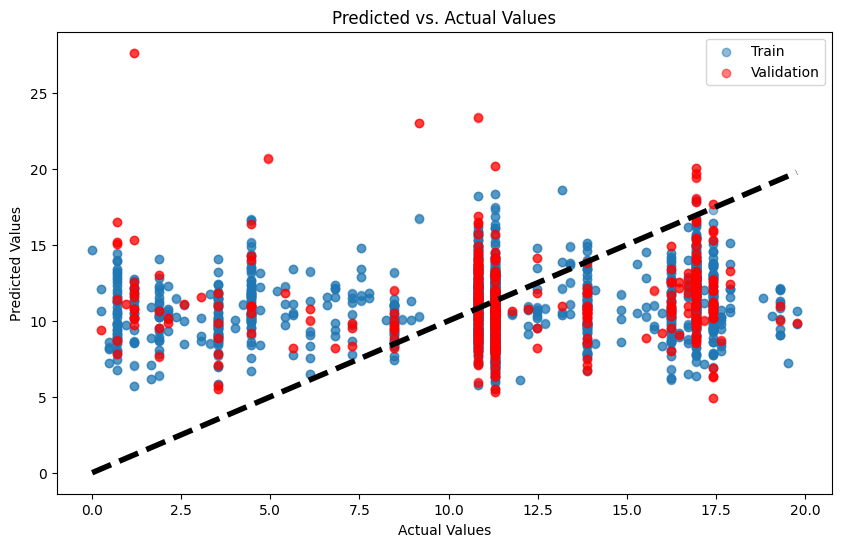

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_targets.numpy(), train_preds.numpy(), alpha=0.5, label='Train')
plt.scatter(val_targets.numpy(), val_preds.numpy(), color='red', alpha=0.5, label='Validation')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=4)
plt.show()

In [ ]:
print(val_preds[90])

tensor([ 0.6753, -0.2099])


In [ ]:
print(val_targets[90])

tensor([0.8235, 0.8235])


In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import numpy as np

data = []
for graph, index in zip(graphs, indices):
    graph.indices = index
    data.append(graph)

# dataset = CustomGraphDataset(graphs, indices)
loader = DataLoader(data, batch_size=1, shuffle=True)

# Define model, optimizer, and loss function
model = DDIGNN(in_channels=3, hidden_channels=8, out_channels=2, edge_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for graph in loader:
        # Forward Pass
        output = model(graph)
        loss = loss_fn(output, graph.y.float())

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        for name, param in model.named_parameters():
          if param.requires_grad and total_loss < 0.01 and name == 'conv1.nn.weight':
            print(f"Gradient for {name}: {param.grad}")


        with torch.no_grad():
          optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')


Gradient for conv1.nn.weight: tensor([[ 3.5433e-06,  0.0000e+00],
        [ 1.4978e-06,  0.0000e+00],
        [-4.6694e-07,  0.0000e+00],
        [-2.5825e-07,  0.0000e+00],
        [-1.6550e-07,  0.0000e+00],
        [-2.6979e-06,  0.0000e+00],
        [-3.3152e-06,  0.0000e+00],
        [-4.9787e-06,  0.0000e+00],
        [ 3.8324e-07,  0.0000e+00],
        [ 6.2108e-07,  0.0000e+00],
        [ 1.4427e-07,  0.0000e+00],
        [-6.5829e-07,  0.0000e+00],
        [ 1.7612e-07,  0.0000e+00],
        [-2.2937e-07,  0.0000e+00],
        [ 9.1003e-07,  0.0000e+00],
        [-5.3700e-07,  0.0000e+00],
        [ 1.2891e-06,  0.0000e+00],
        [ 9.0615e-07,  0.0000e+00],
        [ 5.4767e-07,  0.0000e+00],
        [-4.6455e-07,  0.0000e+00],
        [ 6.4596e-07,  0.0000e+00],
        [-7.6511e-07,  0.0000e+00],
        [ 4.0359e-06,  0.0000e+00],
        [-1.7822e-06,  0.0000e+00]])


KeyboardInterrupt: 